# Gradient boosting model

One, two, you know what to do...

## Notebook set up

### Imports

In [ ]:
# Standard library imports
from itertools import combinations, permutations
from pathlib import Path

# Third party imports
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_selection import SelectPercentile
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler

### Data loading

In [2]:
train_df_path = 'https://gperdrizet.github.io/FSA_devops/assets/data/unit3/diabetes_prediction_train.csv'

# Load the training dataset
train_df = pd.read_csv(train_df_path)

# Display first few rows of training data
train_df.head().transpose()

,0,1,2,3,4
id,0,1,2,3,4
age,31,50,32,54,54
alcohol_consumption_per_week,1,2,3,3,1
physical_activity_minutes_per_week,45,73,158,77,55
diet_score,7.7,5.7,8.5,4.6,5.7
sleep_hours_per_day,6.8,6.5,7.4,7.0,6.2
screen_time_hours_per_day,6.1,5.8,9.1,9.2,5.1
bmi,33.4,23.8,24.1,26.6,28.8
waist_to_hip_ratio,0.93,0.83,0.83,0.83,0.9
systolic_bp,112,120,95,121,108


In [3]:
# Display dataset information (columns, dtypes, non-null counts)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

## 1. Data Preprocessing

In [4]:
# Drop ID column
train_df.drop(columns=['id'], inplace=True)

print(f'ID column removed')
print(f'Remaining columns: {list(train_df.columns)}')

ID column removed
Remaining columns: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes']


## 2. Preprocessing

### 2.1. Column definitions

In [5]:
# Define the label
label = 'diagnosed_diabetes'

# Define numerical features to apply IQR clipping
numerical_features = [
    'age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week',
    'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi',
    'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate',
    'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides',
]

# Define ordinal features to encode
ordinal_features = ['education_level', 'income_level']

# Define ordinal categories in order
education_categories = [['No formal', 'Highschool', 'Graduate', 'Postgraduate']]
income_categories = [['Low', 'Lower-Middle', 'Middle', 'Upper-Middle', 'High']]

# Define features for one-hot encoding
nominal_features = [
    'gender', 'ethnicity', 'smoking_status', 'employment_status',
    'family_history_diabetes', 'hypertension_history', 'cardiovascular_history'
]

### 2.2. Ordinal encoding

In [ ]:
# Create ordinal encoder with categories
ordinal_encoder = OrdinalEncoder(
    categories=education_categories + income_categories,
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

# Fit and transform ordinal features
ordinal_encoded = ordinal_encoder.fit_transform(train_df[ordinal_features])

# Remove original ordinal features and add encoded versions
train_df.drop(columns=ordinal_features, inplace=True)
train_df[ordinal_features] = ordinal_encoded

### 2.3. Nominal encoding

In [7]:
# Create one-hot encoder
onehot_encoder = OneHotEncoder(
    drop='first',
    sparse_output=False,
    handle_unknown='ignore'
)

# Convert encoded features to DataFrame
encoded_features_df = pd.DataFrame(
    onehot_encoder.fit_transform(train_df[nominal_features]),
    columns=onehot_encoder.get_feature_names_out(nominal_features)
)

# Remove original nominal features and add encoded versions
train_df = pd.concat([train_df.drop(columns=nominal_features), encoded_features_df], axis=1)

## 3. Feature engineering

In [8]:
features = train_df.drop(columns=[label]).columns.tolist()
new_features = {}

### 3.1. Difference features

In [9]:
for feature_a, feature_b in combinations(features, 2):
    feature_name = f'{feature_a}-{feature_b}'
    new_features[feature_name] = train_df[feature_a] - train_df[feature_b]

### 3.2. Sum features

In [10]:
for feature_a, feature_b in combinations(features, 2):
    feature_name = f'{feature_a}+{feature_b}'
    new_features[feature_name] = train_df[feature_a] + train_df[feature_b]

### 3.3. Ratio features

In [11]:
for feature_a, feature_b in permutations(features, 2):
    feature_name = f'{feature_a}/{feature_b}'
    new_features[feature_name] = train_df[feature_a] / (train_df[feature_b] + train_df[feature_b].min() + 1)

### 3.4. Reciprocal features

In [12]:
for feature in features:
    feature_name = f'1/{feature}'
    new_features[feature_name] = 1 / (train_df[feature] + train_df[feature].min() + 1)

### 3.5. Log features

In [13]:
for feature in features:
    feature_name = f'log{feature}'
    new_features[feature_name] = np.log(train_df[feature] + train_df[feature].min() + 1)

### 3.6. Square root features

In [14]:
for feature in features:
    feature_name = f'root{feature}'
    new_features[feature_name] = (train_df[feature] + train_df[feature].min() + 1) ** (1/2)

### 3.7. Square features

In [15]:
for feature in features:
    feature_name = f'root{feature}'
    new_features[feature_name] = (train_df[feature] + train_df[feature].min() + 1) ** 2

### 3.6. Add new features

In [16]:
train_df = pd.concat([train_df, pd.DataFrame(new_features)], axis=1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Columns: 1741 entries, age to rootcardiovascular_history_1
dtypes: float64(1631), int64(110)
memory usage: 9.1 GB


## 4. Model training and optimization

### 4.0. Baseline model performance

In [ ]:
# Create baseline model with default parameters
baseline_model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feature_selector', SelectPercentile()),
    ('classifier', HistGradientBoostingClassifier())
])

# Estimate AUC with cross-validation
baseline_scores = cross_val_score(
    baseline_model,
    train_df.drop(columns=['diagnosed_diabetes']),
    train_df['diagnosed_diabetes'],
    cv=3,
    scoring=make_scorer(roc_auc_score)
)

print(f'Baseline model cross-validation mean AUC: {np.mean(baseline_scores):.4f}')

Baseline model cross-validation mean AUC: 0.6237


### 4.1. Hyperparameter optimization with RandomizedSearchCV

In [ ]:
%%time

from scipy.stats import uniform, randint, loguniform

# Define the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feature_selector', SelectPercentile(percentile=10)),
    ('classifier', HistGradientBoostingClassifier(random_state=315))
])

# Best cross-validation score (ROC-AUC): 0.7083

# Best parameters:
#   classifier__early_stopping: True
#   classifier__l2_regularization: 62.63475886951615
#   classifier__learning_rate: 0.03649801250450118
#   classifier__max_bins: 64
#   classifier__max_depth: None
#   classifier__max_iter: 413
#   classifier__min_samples_leaf: 43
#   classifier__n_iter_no_change: 30
#   classifier__validation_fraction: 0.1
#   feature_selector__percentile: 25

# Took 171 minutes on 100,000 samples with n_jobs=1

# Define parameter distributions for randomized search
param_distributions = {
    'feature_selector__percentile': uniform(0.25, 0.95),
    'classifier__learning_rate': loguniform(0.001, 0.3),
    'classifier__max_iter': randint(100, 501),
    'classifier__max_depth': [10, 15, 20, 25, None],
    'classifier__min_samples_leaf': randint(5, 51),
    'classifier__l2_regularization': loguniform(1e-4, 100.0),
    'classifier__max_bins': [64, 128, 255],
    'classifier__early_stopping': [True],
    'classifier__validation_fraction': [0.1],
    'classifier__n_iter_no_change': [30]
}

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=200,
    cv=3,
    scoring='roc_auc',
    n_jobs=1,
    random_state=315,
    verbose=0
)

# Fit the randomized search
sample_df = train_df.sample(n=100000, random_state=315)

random_search.fit(
    sample_df.drop(columns=['diagnosed_diabetes']),
    sample_df['diagnosed_diabetes']
)

print(f'\nBest single cross-validation score (ROC-AUC): {random_search.best_score_:.4f}')
print(f'\nBest parameters:')

for param, value in random_search.best_params_.items():
    print(f'  {param}: {value}')

print()


Best cross-validation score (ROC-AUC): 0.7083

Best parameters:
  classifier__early_stopping: True
  classifier__l2_regularization: 62.63475886951615
  classifier__learning_rate: 0.03649801250450118
  classifier__max_bins: 64
  classifier__max_depth: None
  classifier__max_iter: 413
  classifier__min_samples_leaf: 43
  classifier__n_iter_no_change: 30
  classifier__validation_fraction: 0.1
  feature_selector__percentile: 25

CPU times: user 20h 16s, sys: 14min 38s, total: 20h 14min 55s
Wall time: 2h 51min 2s


### 4.2. Evaluate optimized model

In [ ]:
# Get the best model from random search
best_model = random_search.best_estimator_

# Evaluate with cross-validation to verify performance
scores = cross_val_score(
    best_model,
    train_df.drop(columns=['diagnosed_diabetes']),
    train_df['diagnosed_diabetes'],
    cv=3,
    scoring=make_scorer(roc_auc_score),
    n_jobs=-1
)

print(f'Optimized model cross-validation mean AUC: {np.mean(scores):.4f}')

Optimized model cross-validation mean AUC: 0.6285


### 4.4. Compare baseline vs optimized performance

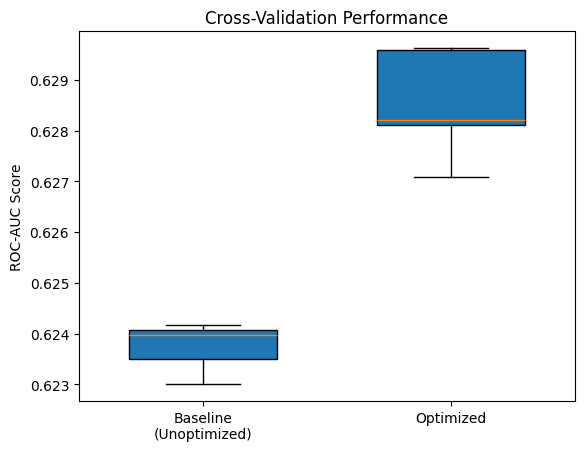

Baseline  - Mean: 0.6237, Std: 0.0005
Optimized - Mean: 0.6285, Std: 0.0010


In [22]:
# Prepare data for boxplot
comparison_data = [baseline_scores, scores]
labels = ['Baseline\n(Unoptimized)', 'Optimized']

# Create boxplot
plt.title('Cross-Validation Performance')
plt.boxplot(comparison_data, tick_labels=labels, patch_artist=True, widths=0.6)
plt.ylabel('ROC-AUC Score')
plt.show()

# Print summary statistics
print(f'Baseline  - Mean: {np.mean(baseline_scores):.4f}, Std: {np.std(baseline_scores):.4f}')
print(f'Optimized - Mean: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}')

### 4.5. Confusion matrices

In [ ]:
# Get predictions for both models using cross-validation
baseline_predictions = cross_val_predict(
    baseline_model,
    train_df.drop(columns=['diagnosed_diabetes']),
    train_df['diagnosed_diabetes'],
    cv=3
)

optimized_predictions = cross_val_predict(
    best_model,
    train_df.drop(columns=['diagnosed_diabetes']),
    train_df['diagnosed_diabetes'],
    cv=3
)

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Baseline confusion matrix
axes[0].set_title('Unoptimized model')

disp1 = ConfusionMatrixDisplay.from_predictions(
    train_df['diagnosed_diabetes'],
    baseline_predictions,
    normalize='true',
    ax=axes[0],
    colorbar=False
)

# Optimized confusion matrix
axes[0].set_title('Unoptimized model')

disp3 = ConfusionMatrixDisplay.from_predictions(
    train_df['diagnosed_diabetes'],
    optimized_predictions,
    normalize='true',
    ax=axes[0],
    colorbar=False
)

plt.tight_layout()
plt.show()

## 5. Save Model

In [ ]:
# Define model directory and ensure it exists
model_dir = Path('../models')
model_dir.mkdir(parents=True, exist_ok=True)

# Create model filename
model_name = 'gradient_boosting'
model_path = model_dir / f'{model_name}.joblib'

# Save the final model
joblib.dump(best_model, model_path)
print('Model saved to:', model_path)
print(f'File size: {model_path.stat().st_size / (1024**2):.2f} MB')